In [325]:
import sys
sys.path.append('src/')

import spiceypy as spice
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt

In [326]:
pi      = np.pi
deg2rad = pi / 180.0
rad2deg = 180.0 / pi

min2rad = deg2rad / 60.0
rad2min = rad2deg * 60.0

sec2rad = min2rad / 60.0
rad2sec = rad2min * 60.0

### Lambert - Vallado

In [327]:
def mag(vec):
    return np.linalg.norm(vec)

def findc2c3(znew):
    small = 1e-8
    if znew > small:
        sqrtz = np.sqrt(znew)
        c2 = (1.0 - np.cos(sqrtz)) / znew
        c3 = (sqrtz - np.sin(sqrtz)) / (sqrtz**3)
    elif znew < -small:
        sqrtz = np.sqrt(-znew)
        c2 = (1.0 - np.cosh(sqrtz)) / znew
        c3 = (np.sinh(sqrtz) - sqrtz) / (sqrtz**3)
    else:
        c2 = 0.5
        c3 = 1.0 / 6.0
    return c2, c3


# ------------------------------------------------------------------------------
#
#                           function lambertu
#
#  this function solves the lambert problem for orbit determination and returns
#    the velocity vectors at each of two given position vectors.  the solution
#    uses universal variables for calculation and a bissection technique
#    updating psi.
#
#  author        : david vallado                  719-573-2600    1 mar 2001
#
#  inputs          description                    range / units
# Following line added by Barrows 1/2014
#    mu          - central body gravitational parameter  km^3/sec^2
#    r1          - ijk position vector 1          km
#    r2          - ijk position vector 2          km
#    dm          - direction of motion            'l','s'
#    dtsec       - time between r1 and r2         s
#    nrev        - multiple revoluions            0, 1, ...
#
#  outputs       :
#    v1          - ijk velocity vector            km / s
#    v2          - ijk velocity vector            km / s
#    error       - error flag                     'ok', ...
#
#  locals        :
#    vara        - variable of the iteration,
#                  not the semi-axis
#    y           - area between position vectors
#    upper       - upper bound for z
#    lower       - lower bound for z
#    cosdeltanu  - cosine of true anomaly change  rad
#    f           - f expression
#    g           - g expression
#    gdot        - g dot expression
#    xold        - old universal variable x
#    xoldcubed   - xold cubed
#    zold        - old value of z
#    znew        - new value of z
#    c2new       - c2(z) function
#    c3new       - c3(z) function
#    timenew     - new time                       s
#    small       - tolerance for roundoff errors
#    i, j        - index
#
#  coupling      :
#    mag         - magnitude of a vector
#    dot         - dot product of two vectors
#    findc2c3    - find c2 and c3 functions
#
#  references    :
#    vallado       2001, 459-464, alg 55, ex 7-5
#
# [vo,v,errorl] = lambertu ( ro,r, dm, nrev, dtsec );
# ------------------------------------------------------------------------------



def lambert_vallado_universal(mu, r1, r2, dm, nrev, dtsec):
    small = 1e-5
    twopi = 2.0 * np.pi
    numiter = 500
    errorl = "ok"

    ro = r1
    r = r2
    magro = mag(ro)
    magr = mag(r)
    vo = np.zeros(3)
    v = np.zeros(3)

    cosdeltanu = nrev + np.dot(ro, r) / (magro * magr)
    vara = -np.sqrt(magro * magr * (1.0 + cosdeltanu)) if dm == 'l' else np.sqrt(magro * magr * (1.0 + cosdeltanu))

    if abs(vara) <= small:
        return vo, v, "impos180"

    # Initial guesses
    psiold = 0.0
    c2new = 0.5
    c3new = 1.0 / 6.0

    # Bounds for psi
    if nrev == 0:
        upper = 4.0 * np.pi ** 2
        lower = -4.0 * twopi * np.pi
    elif nrev == 1:
        upper = 16.0 * np.pi ** 2
        lower = 4.0 * np.pi ** 2
    else:
        upper = 36.0 * np.pi ** 2
        lower = 16.0 * np.pi ** 2

    loops = 0
    ynegktr = 1
    dtnew = -10.0

    while abs(dtnew - dtsec) >= small and loops < numiter and ynegktr <= 10:
        if abs(c2new) > small:
            y = magro + magr - (vara * (1.0 - psiold * c3new) / np.sqrt(c2new))
        else:
            y = magro + magr

        if vara > 0.0 and y < 0.0:
            while y < 0.0 and ynegktr < 10:
                psinew = 0.8 * (1.0 / c3new) * (1.0 - (magro + magr) * np.sqrt(c2new) / vara)
                c2new, c3new = findc2c3(psinew)
                psiold = psinew
                lower = psiold
                if abs(c2new) > small:
                    y = magro + magr - (vara * (1.0 - psiold * c3new) / np.sqrt(c2new))
                else:
                    y = magro + magr
                ynegktr += 1

        if ynegktr < 10:
            xold = np.sqrt(y / c2new) if abs(c2new) > small else 0.0
            xoldcubed = xold ** 3
            dtnew = (xoldcubed * c3new + vara * np.sqrt(y)) / np.sqrt(mu)

            if dtnew < dtsec:
                lower = psiold
            if dtnew > dtsec:
                upper = psiold

            psinew = 0.5 * (upper + lower)
            c2new, c3new = findc2c3(psinew)
            psiold = psinew
            loops += 1

            if abs(dtnew - dtsec) < small and loops == 1:
                dtnew = dtsec - 1.0

    if loops >= numiter or ynegktr >= 10:
        errorl = "gnotconv" if ynegktr < 10 else "y negati"
    else:
        f = 1.0 - y / magro
        gdot = 1.0 - y / magr
        g = 1.0 / (vara * np.sqrt(y / mu))

        vo = (r - f * ro) * g
        v = (gdot * r - ro) * g

    return vo, v, errorl


### Lambert - Curtis

In [328]:
def stumpS(z):
    """
    Stumpff function S(z), Eq. 3.52
    """
    if z > 0:
        return (np.sqrt(z) - np.sin(np.sqrt(z))) / z**1.5
    elif z < 0:
        return (np.sinh(np.sqrt(-z)) - np.sqrt(-z)) / (-z)**1.5
    else:
        return 1.0/6.0

def stumpC(z):
    """
    Stumpff function C(z), Eq. 3.53
    """
    if z > 0:
        return (1 - np.cos(np.sqrt(z))) / z
    elif z < 0:
        return (np.cosh(np.sqrt(-z)) - 1) / (-z)
    else:
        return 0.5

# ------------------------------------------------------------------------------
#
# This function solves Lambert's problem.
# 
#   mu         - gravitational parameter (km^3/s^2)
#   R1, R2     - initial and final position vectors (km)
#   r1, r2     - magnitudes of R1 and R2
#   t          - the time of flight from R1 to R2 (a constant) (s)
#   V1, V2     - initial and final velocity vectors (km/s)
#   c12        - cross product of R1 into R2
#   theta      - angle between R1 and R2
#   string     - 'pro'   if the orbit is prograde
#                'retro' if the orbit is retrograde
#   A          - a constant given by Equation 5.35
#   z          - alpha*x^2, where alpha is the reciprocal of the
#                semimajor axis and x is the universal anomaly
#   y(z)       - a function of z given by Equation 5.38
#   F(z,t)     - a function of the variable z and constant t,
#              - given by Equation 5.40
#   dFdz(z)    - the derivative of F(z,t), given by Equation 5.43
#   ratio      - F/dFdz
#   tol        - tolerance on precision of convergence
#   nmax       - maximum number of iterations of Newton's procedure
#   f, g       - Lagrange coefficients
#   gdot       - time derivative of g
#   C(z), S(z) - Stumpff functions
#   dum        - a dummy variable
#   dm should be 'pro' (prograde) or 'retro' (retrograde)
#   nrev is ignored (no multi-revolution solutions)
#
# ------------------------------------------------------------------------------

def AA279lambert_curtis(mu, R1, R2, dm='pro', nrev=0, dtsec=0.0):
    # --- Setup and geometry
    R1 = np.asarray(R1, float)
    R2 = np.asarray(R2, float)
    t  = dtsec
    
    r1 = np.linalg.norm(R1)
    r2 = np.linalg.norm(R2)
    
    c12 = np.cross(R1, R2)
    theta = np.arccos(np.dot(R1, R2) / (r1 * r2))
    
    if dm not in ('pro', 'retro'):
        print("** Prograde trajectory assumed.")
        dm = 'pro'
    if dm == 'pro':
        if c12[2] <= 0:
            theta = 2*np.pi - theta
    else:
        if c12[2] >= 0:
            theta = 2*np.pi - theta
    
    # Constant A, Eq. 5.35
    A = np.sin(theta) * np.sqrt(r1 * r2 / (1 - np.cos(theta)))
    
    # Nested y(z)
    def y(z):
        Cz = stumpC(z)
        Sz = stumpS(z)
        return r1 + r2 + A*(z*Sz - 1)/np.sqrt(Cz)
    
    # Safeguarded F(z)
    def F(z):
        Cz = stumpC(z)
        Sz = stumpS(z)
        yz = y(z)
        if yz <= 0 or Cz <= 0:
            return np.nan
        return (yz/Cz)**1.5 * Sz + A*np.sqrt(yz) - np.sqrt(mu)*t
    
    # Safeguarded derivative dF/dz
    def dFdz(z):
        Cz = stumpC(z)
        Sz = stumpS(z)
        yz = y(z)
        if yz <= 0 or Cz <= 0:
            return np.nan
        # special-case near z=0
        if abs(z) < 1e-8:
            return (np.sqrt(2)/40)*yz**1.5 + A/8*(np.sqrt(yz) + A*np.sqrt(1/(2*yz)))
        # general form
        term1 = (yz/Cz)**1.5 * (
            0.5/z*(Cz - 3*Sz/(2*Cz))
            + 3*Sz**2/(4*Cz)
        )
        term2 = A/8 * (3*Sz/Cz*np.sqrt(yz) + A*np.sqrt(Cz/yz))
        return term1 + term2
    
    # --- Bracket-search for F(z)>=0
    z = -100.0
    max_z = 1e6
    while True:
        fz = F(z)
        if np.isfinite(fz) and fz >= 0:
            break
        z += 0.1
        if z > max_z:
            raise RuntimeError("Failed to bracket root for F(z).")
    
    # --- Newton iteration
    tol  = 1e-8
    nmax = 5000
    for i in range(nmax):
        fz = F(z)
        df = dFdz(z)
        ratio = fz / df
        if not np.isfinite(ratio):
            raise RuntimeError(f"Newton diverged at iter {i}, z={z}")
        z -= ratio
        if abs(ratio) < tol:
            break
    else:
        raise RuntimeError(f"Lambert solver failed to converge in {nmax} iters.")
    
    # --- Lagrange coefficients & velocities
    yz = y(z)
    f   = 1 - yz/r1
    g   = A * np.sqrt(yz/mu)
    gdot = 1 - yz/r2
    
    v1 = (R2 - f*R1) / g
    v2 = (gdot*R2 - R1) / g
    
    return v1, v2, 'finished'


### SPICE

In [329]:
spice.furnsh("SPICE/cassini_kernels/naif0010.tls")
spice.furnsh("SPICE/spk/mar097.bsp")
spice.furnsh("SPICE/spk/de441_part-1.bsp")
spice.furnsh("SPICE/spk/de441_part-2.bsp")

### Utility Functions

In [330]:
def date_to_et(date):
    return spice.utc2et(date.strftime("%Y-%m-%dT%H:%M:%S"))

def et_to_date(et):
    return spice.et2datetime(et)

def get_planet_state(body, et, frame='ECLIPJ2000', observer='SUN'):
    state, _ = spice.spkezr(body, et, frame, 'NONE', observer)
    r = state[:3]
    v = state[3:]
    return np.array(r), np.array(v)

### Constants and Time Grid

In [ ]:
mu_sun = 1.32712440018e11  # [km^3/s^2]

# Generate launch dates
# dep_dates = [datetime(year, month, 1) for year in range(2000,2010) for month in (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)]
# dep_dates = [datetime(year, month, day) for year in range (2001, 2008) for month in range (1, 12) for day in range (1, 28)]
dep_dates = [datetime(2005, month, day) for month in range (4, 12) for day in range (1, 28)]


dep_ets = [date_to_et(d) for d in dep_dates]

# For each departure, set arrival dates
arrival_day_range = np.arange(100, 650, 2)  # days
arr_ets_list = [[et + days * 86400 for days in arrival_day_range] for et in dep_ets]


### Evaluate delta V

In [332]:
num_dep = len(dep_ets)
num_arr = len(arrival_day_range)

delta_v_short = np.full((num_dep, num_arr), np.nan)
delta_v_long = np.full((num_dep, num_arr), np.nan)

for i, t_dep in enumerate(dep_ets):
    r1, v_earth = get_planet_state('EARTH', t_dep)

    for j, t_arr in enumerate(arr_ets_list[i]):
        r2, v_mars = get_planet_state('MARS', t_arr)
        dt = t_arr - t_dep  # seconds

        try:
            # Short-way
            v1_s, v2_s, _ = lambert_vallado_universal(mu_sun, r1, r2, 's', 0, dt)
            dv1_s = np.linalg.norm(v1_s - v_earth)
            dv2_s = np.linalg.norm(v2_s - v_mars)
            delta_v_short[i, j] = dv1_s + dv2_s

            # Long-way
            v1_l, v2_l, _ = lambert_vallado_universal(mu_sun, r1, r2, 'l', 0, dt)
            dv1_l = np.linalg.norm(v1_l - v_earth)
            dv2_l = np.linalg.norm(v2_l - v_mars)
            delta_v_long[i, j] = dv1_l + dv2_l

        except:
            continue


### Plot Pork Chop Plots

C:\Users\Timmy\AppData\Local\Temp\ipykernel_26132\1544602654.py:32: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(pcm_s, ax=ax, orientation='vertical', pad=0.02)


TOF contour levels: [100, 200, 300, 400, 500, 600]


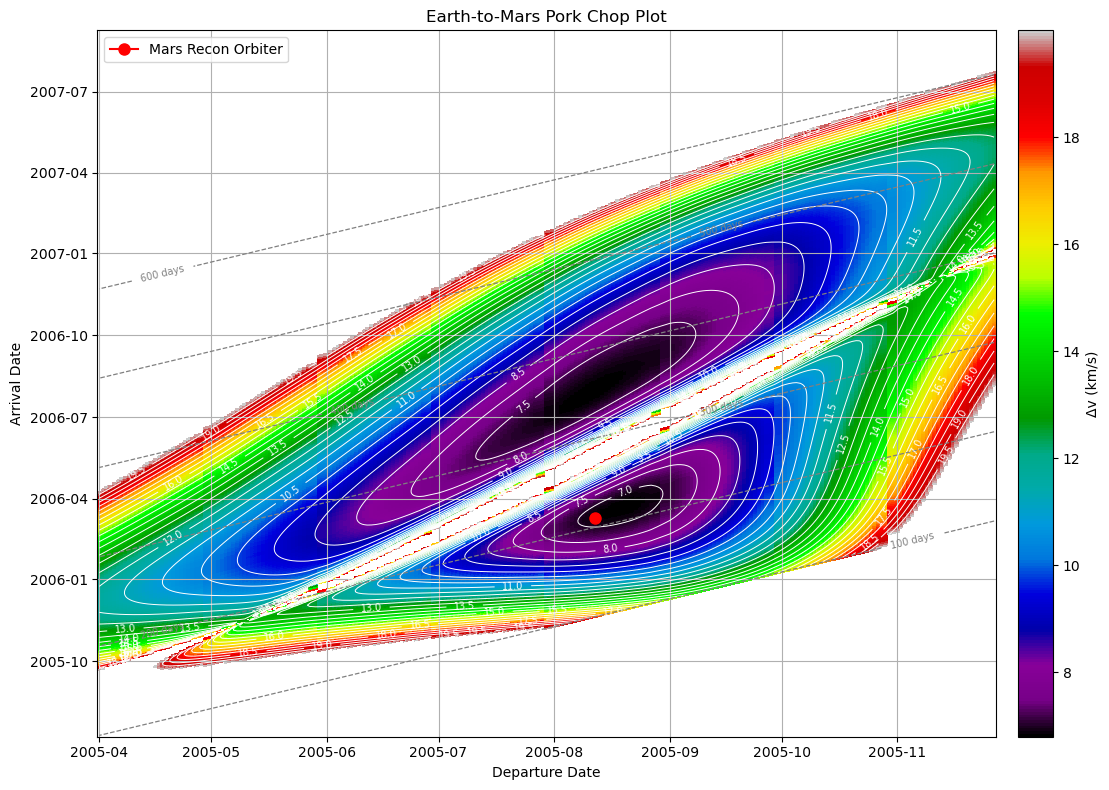

In [338]:
# Convert arrival_day_range (in days) to datetime arrays
arr_dates_matrix = [[dep_dates[i] + timedelta(days=int(dt))
                     for dt in arrival_day_range]
                    for i in range(len(dep_dates))]

X = np.array([[d for _ in arrival_day_range] for d in dep_dates])  # Departure dates (x-axis)
Y = np.array(arr_dates_matrix)  # Arrival dates (y-axis)

# === Time of Flight Matrix (in days) ===
TOF_days = np.array([[ (arr - dep).days for arr in row ] for dep, row in zip(dep_dates, arr_dates_matrix)])

# Set Δv threshold
dv_threshold = 20.0  # km/s

# Mask values above threshold
dv_s_masked = np.where(delta_v_short <= dv_threshold, delta_v_short, np.nan)
dv_l_masked = np.where(delta_v_long <= dv_threshold, delta_v_long, np.nan)

# Set Δv contour levels in 0.5 km/s steps
dv_contour_levels = np.arange(7, dv_threshold + 0.1, 0.5)

# === Plot setup ===
fig, ax = plt.subplots(figsize=(12, 8))

# Background: short-way Δv
pcm_s = ax.pcolor(X, Y, dv_s_masked, cmap='nipy_spectral', shading='auto')

# Overlay: long-way Δv (transparent)
pcm_l = ax.pcolor(X, Y, dv_l_masked, cmap='nipy_spectral', shading='auto')

# Colorbar: single for short-way Δv
cbar = fig.colorbar(pcm_s, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label("Δv (km/s)")

# === Contours: short-way (white) ===
cp_s = ax.contour(X, Y, dv_s_masked, levels=dv_contour_levels, colors='white', linewidths=0.7)
ax.clabel(cp_s, inline=True, fontsize=7, fmt="%.1f")

# === Contours: long-way (white) ===
cp_l = ax.contour(X, Y, dv_l_masked, levels=dv_contour_levels, colors='white', linewidths=0.7)
ax.clabel(cp_l, inline=True, fontsize=7, fmt="%.1f")

# === Time of Flight (TOF) contours ===
tof_levels = list(np.arange(100, 650, 100))

print("TOF contour levels:", tof_levels)

TOF_days_int = np.round(TOF_days).astype(int)
cp_tof = ax.contour(X, Y, TOF_days_int, levels=tof_levels, colors='gray', linestyles='dashed', linewidths=0.9)
ax.clabel(cp_tof, fmt='%d days', fontsize=7, colors='gray')

# === Historical mission marker ===
missions = [
    # {"name": "2001 Mars Odyssey", "dep": datetime(2001, 4, 7),  "arr": datetime(2001, 10, 24), "color": "cyan"},
    # {"name": "Mars Express",      "dep": datetime(2003, 6, 2),  "arr": datetime(2003, 12, 25), "color": "orange"},
    # {"name": "MER-B Opportunity", "dep": datetime(2003, 7, 7),  "arr": datetime(2004, 1, 25),  "color": "yellow"},
    {"name": "Mars Recon Orbiter","dep": datetime(2005, 8, 12), "arr": datetime(2006, 3, 10),  "color": "red"},
    # {"name": "Phoenix",           "dep": datetime(2007, 8, 4),  "arr": datetime(2008, 5, 25),  "color": "lime"},
]

for m in missions:
    ax.plot(m["dep"], m["arr"], marker='o', color=m["color"], markersize=8, label=m["name"], zorder = 10)

# === Labels and grid ===
ax.set_title("Earth-to-Mars Pork Chop Plot")
ax.set_xlabel("Departure Date")
ax.set_ylabel("Arrival Date")
ax.grid(True)
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()